## Develop a time series forecasting model to predict future monthly sales across different regions and product categories using historical order data. The goal is to enable proactive inventory planning and revenue forecasting.

## 1. Importing the Libraries


In [109]:
# Importing all the libraries
%pip install prophet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
import xgboost as xgb
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')


Note: you may need to restart the kernel to use updated packages.


In [110]:
# Load the Dataset
df = pd.read_excel(r'C:\Users\Rahul\Desktop\DSA\Data_Science\Time_Series_Forecasting\data\INDIA_RETAIL_DATA.xlsx')
df.head()

,Order Priority,Discount offered,Unit Price,Freight Expenses,Freight Mode,Segment,Product Type,Product Sub-Category,Product Container,State,City,Region,Country,Order Date,Ship Date,Profit,QtyOrdered,Sales
0,High,0.06,40.98,2.99,Regular Air,Personel Usage,Processed Meat,Bacon,Small Box,Madhya Pradesh,Rewa,West,India,2010-01-02,2010-01-04,-19.0992,3,124.81
1,High,0.05,155.06,7.07,Regular Air,Hotels / Hospitals,Processed Meat,Fresh Water Eel,Small Box,Meghalaya,Shillong,East,India,2010-01-02,2010-01-09,845.6640,8,1225.60
2,High,0.09,9.11,2.15,Express Air,Personel Usage,Processed Meat,Smoked Salmon,Wrap Bag,Maharashtra,Parbhani,West,India,2010-01-02,2010-01-04,20.2996,4,34.41
3,High,0.08,15.04,1.97,Regular Air,Personel Usage,Processed Meat,Smoked Salmon,Wrap Bag,Maharashtra,Parbhani,West,India,2010-01-02,2010-01-02,108.5163,11,157.27
4,High,0.03,4.26,1.20,Regular Air,Restaurant Chain,Processed Meat,Foie Gras,Wrap Bag,Uttar Pradesh,Ghaziabad,North,India,2010-01-03,2010-01-04,9.8200,29,122.23


## 2. Data Preprocessing

In [111]:
# Extracting the info from the dataset
df.info()
df.dtypes.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2534 entries, 0 to 2533
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Order Priority        2534 non-null   object        
 1   Discount offered      2534 non-null   float64       
 2   Unit Price            2534 non-null   float64       
 3   Freight Expenses      2534 non-null   float64       
 4   Freight Mode          2534 non-null   object        
 5   Segment               2534 non-null   object        
 6   Product Type          2534 non-null   object        
 7   Product Sub-Category  2534 non-null   object        
 8   Product Container     2534 non-null   object        
 9   State                 2534 non-null   object        
 10  City                  2534 non-null   object        
 11  Region                2534 non-null   object        
 12  Country               2534 non-null   object        
 13  Order Date        

object            10
float64            5
datetime64[ns]     2
int64              1
Name: count, dtype: int64

In [112]:
# Describing the dataset
df.describe()

,Discount offered,Unit Price,Freight Expenses,Order Date,Ship Date,Profit,QtyOrdered,Sales
count,2534.000000,2534.000000,2534.000000,2534,2534,2534.000000,2534.000000,2534.000000
mean,0.049650,100.151405,12.222261,2012-03-14 20:56:26.898184704,2012-03-16 21:46:27.371744512,112.576198,14.238358,992.623717
min,0.000100,0.990000,0.490000,2010-01-02 00:00:00,2010-01-02 00:00:00,-14369.123580,1.000000,1.620000
25%,0.020000,6.480000,2.990000,2011-03-12 00:00:00,2011-03-13 00:00:00,-86.377263,5.000000,62.592500
50%,0.050000,20.890000,6.050000,2012-05-12 00:00:00,2012-05-14 00:00:00,1.231250,10.000000,191.160000
75%,0.080000,89.950000,12.980000,2013-03-26 00:00:00,2013-03-28 00:00:00,121.263000,17.000000,793.847500
max,0.100000,6783.020000,110.200000,2013-12-30 00:00:00,2013-12-30 00:00:00,16332.414000,170.000000,100119.160000
std,0.032171,357.023226,16.092475,NaN,NaN,1055.205939,16.014995,3147.339693


<Axes: >

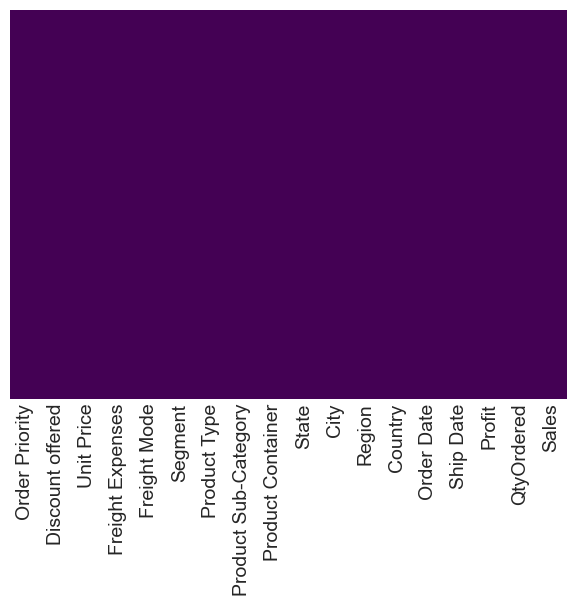

In [113]:
# Checking for missing values
df.isnull().sum()
# We can see that there are no missing values in the dataset
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap='viridis')

In [114]:
# We can see that there are 2 columns that have datetime object
# Converting the date columns to datetime format
df["Order Date"] = pd.to_datetime(df["Order Date"])
df["Ship Date"] = pd.to_datetime(df["Ship Date"])

# Checking the data types again
df.dtypes.value_counts()
df["Order Date"]
df["Ship Date"]

0      2010-01-04
1      2010-01-09
2      2010-01-04
3      2010-01-02
4      2010-01-04
          ...    
2529   2013-12-30
2530   2013-12-30
2531   2013-12-29
2532   2013-12-30
2533   2013-12-30
Name: Ship Date, Length: 2534, dtype: datetime64[ns]

In [115]:
# Create a new COlumn for year, month and day for time series analysis
df["Year"] = df["Order Date"].dt.year
df["Month"] = df["Order Date"].dt.month
df["Day"] = df["Order Date"].dt.day

# Checking the new columns
df.head()


,Order Priority,Discount offered,Unit Price,Freight Expenses,Freight Mode,Segment,Product Type,Product Sub-Category,Product Container,State,...,Region,Country,Order Date,Ship Date,Profit,QtyOrdered,Sales,Year,Month,Day
0,High,0.06,40.98,2.99,Regular Air,Personel Usage,Processed Meat,Bacon,Small Box,Madhya Pradesh,...,West,India,2010-01-02,2010-01-04,-19.0992,3,124.81,2010,1,2
1,High,0.05,155.06,7.07,Regular Air,Hotels / Hospitals,Processed Meat,Fresh Water Eel,Small Box,Meghalaya,...,East,India,2010-01-02,2010-01-09,845.6640,8,1225.60,2010,1,2
2,High,0.09,9.11,2.15,Express Air,Personel Usage,Processed Meat,Smoked Salmon,Wrap Bag,Maharashtra,...,West,India,2010-01-02,2010-01-04,20.2996,4,34.41,2010,1,2
3,High,0.08,15.04,1.97,Regular Air,Personel Usage,Processed Meat,Smoked Salmon,Wrap Bag,Maharashtra,...,West,India,2010-01-02,2010-01-02,108.5163,11,157.27,2010,1,2
4,High,0.03,4.26,1.20,Regular Air,Restaurant Chain,Processed Meat,Foie Gras,Wrap Bag,Uttar Pradesh,...,North,India,2010-01-03,2010-01-04,9.8200,29,122.23,2010,1,3


In [116]:

# Creating a year,month column for time based analysis
df['Year_Month'] = df['Order Date'].dt.to_period('M')
# Sorting the data by order Date
df.sort_values(by='Order Date',inplace=True)
df.head()

,Order Priority,Discount offered,Unit Price,Freight Expenses,Freight Mode,Segment,Product Type,Product Sub-Category,Product Container,State,...,Country,Order Date,Ship Date,Profit,QtyOrdered,Sales,Year,Month,Day,Year_Month
0,High,0.06,40.98,2.99,Regular Air,Personel Usage,Processed Meat,Bacon,Small Box,Madhya Pradesh,...,India,2010-01-02,2010-01-04,-19.0992,3,124.81,2010,1,2,2010-01
1,High,0.05,155.06,7.07,Regular Air,Hotels / Hospitals,Processed Meat,Fresh Water Eel,Small Box,Meghalaya,...,India,2010-01-02,2010-01-09,845.6640,8,1225.60,2010,1,2,2010-01
2,High,0.09,9.11,2.15,Express Air,Personel Usage,Processed Meat,Smoked Salmon,Wrap Bag,Maharashtra,...,India,2010-01-02,2010-01-04,20.2996,4,34.41,2010,1,2,2010-01
3,High,0.08,15.04,1.97,Regular Air,Personel Usage,Processed Meat,Smoked Salmon,Wrap Bag,Maharashtra,...,India,2010-01-02,2010-01-02,108.5163,11,157.27,2010,1,2,2010-01
8,High,0.04,10.14,2.27,Regular Air,Hotels / Hospitals,Processed Meat,Smoked Salmon,Wrap Bag,Andhra Pradesh,...,India,2010-01-03,2010-01-07,24.9240,3,30.94,2010,1,3,2010-01


In [117]:
# Shape of the dataset
df.shape


(2534, 22)

In [118]:
# Checking the unique values in the dataset
df.nunique()

df.columns

Index(['Order Priority', 'Discount offered', 'Unit Price', 'Freight Expenses',
       'Freight Mode', 'Segment', 'Product Type', 'Product Sub-Category',
       'Product Container', 'State', 'City', 'Region', 'Country', 'Order Date',
       'Ship Date', 'Profit', 'QtyOrdered', 'Sales', 'Year', 'Month', 'Day',
       'Year_Month'],
      dtype='object')

## 3. EDA (Exploratory Data Analysis)

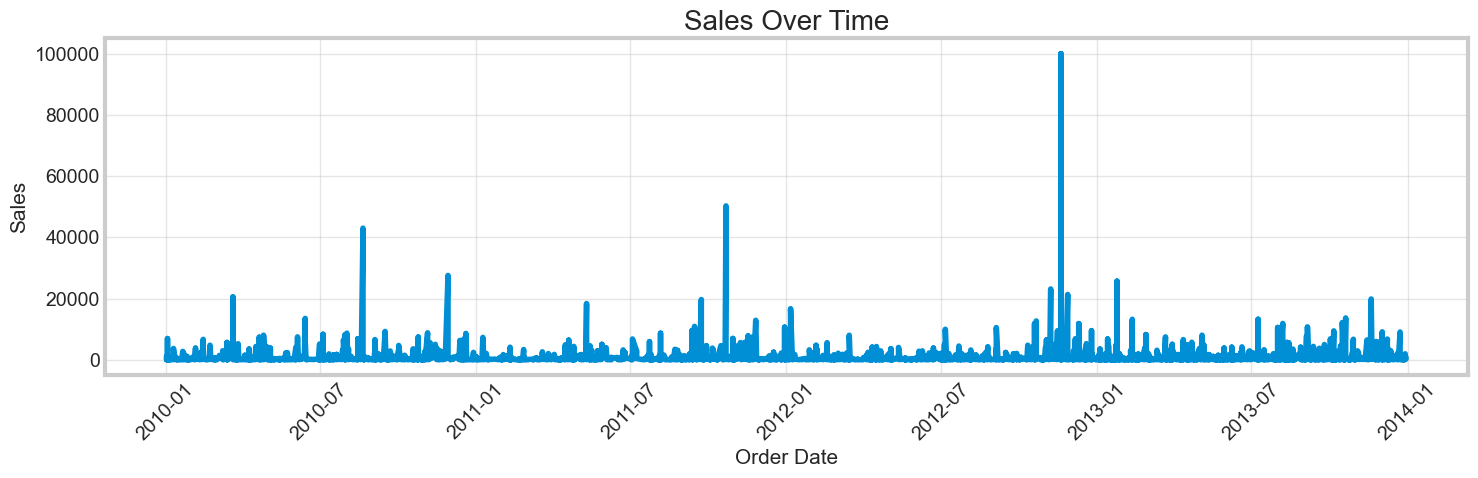

In [119]:
# 1. Time Specfic Analysis
# Time Series Analysis

plt.figure(figsize=(15,5))
plt.plot(df['Order Date'],df['Sales'])
plt.title('Sales Over Time',fontsize=20)
plt.xlabel('Order Date',fontsize=15)
plt.ylabel('Sales',fontsize=15)
plt.grid(True,alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


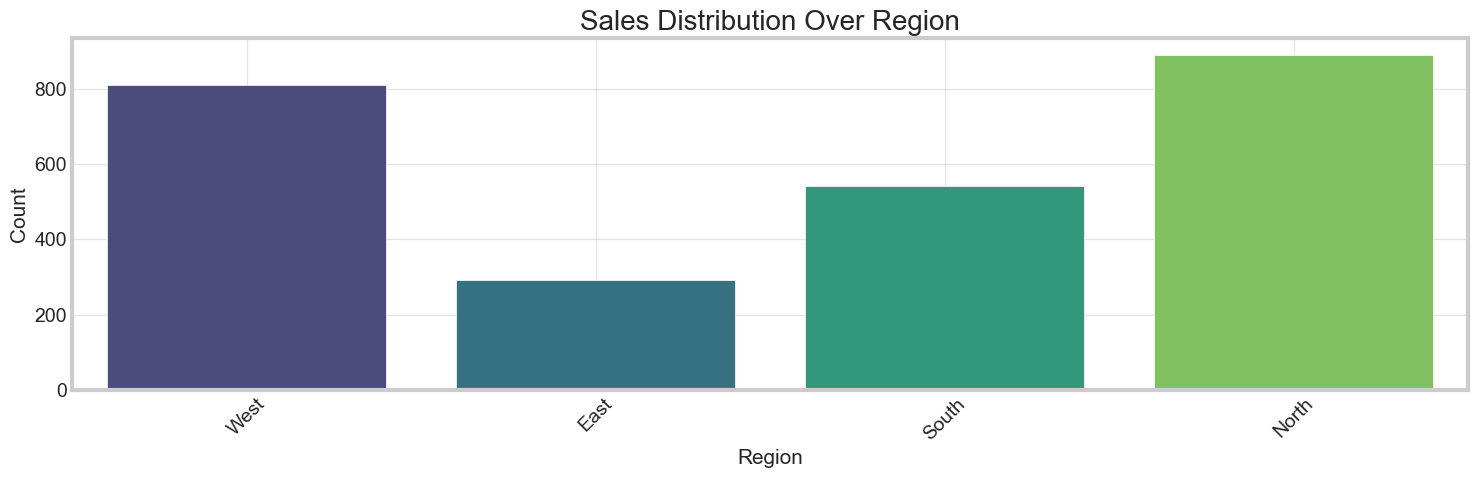

In [120]:
# Sales Distribution Over Region
plt.figure(figsize=(15,5))
sns.countplot(x='Region',data=df,palette='viridis')
plt.title('Sales Distribution Over Region',fontsize=20)
plt.xlabel('Region',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.grid(True,alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


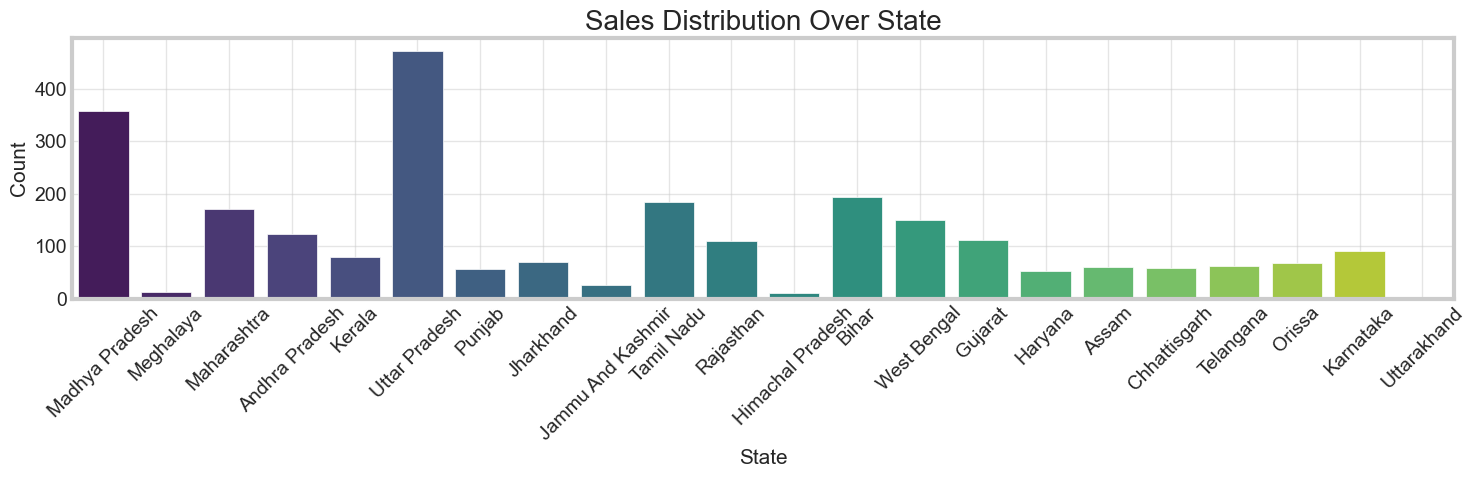

In [121]:
# Sales Distribution Over State
plt.figure(figsize=(15,5))
sns.countplot(x='State',data=df,palette='viridis')
plt.title('Sales Distribution Over State',fontsize=20)
plt.xlabel('State',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.grid(True,alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


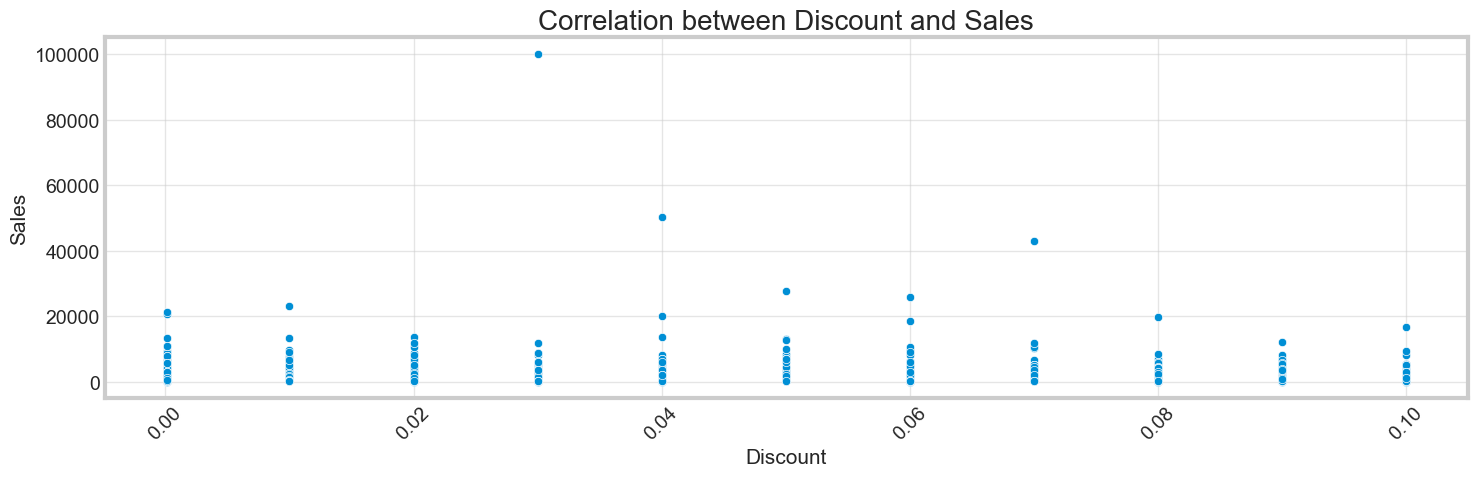

In [122]:
# Correlation between Discount and Sales
plt.figure(figsize=(15,5))
sns.scatterplot(x='Discount offered',y='Sales',data=df,palette='viridis')
plt.title('Correlation between Discount and Sales',fontsize=20)
plt.xlabel('Discount',fontsize=15)
plt.ylabel('Sales',fontsize=15)
plt.grid(True,alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


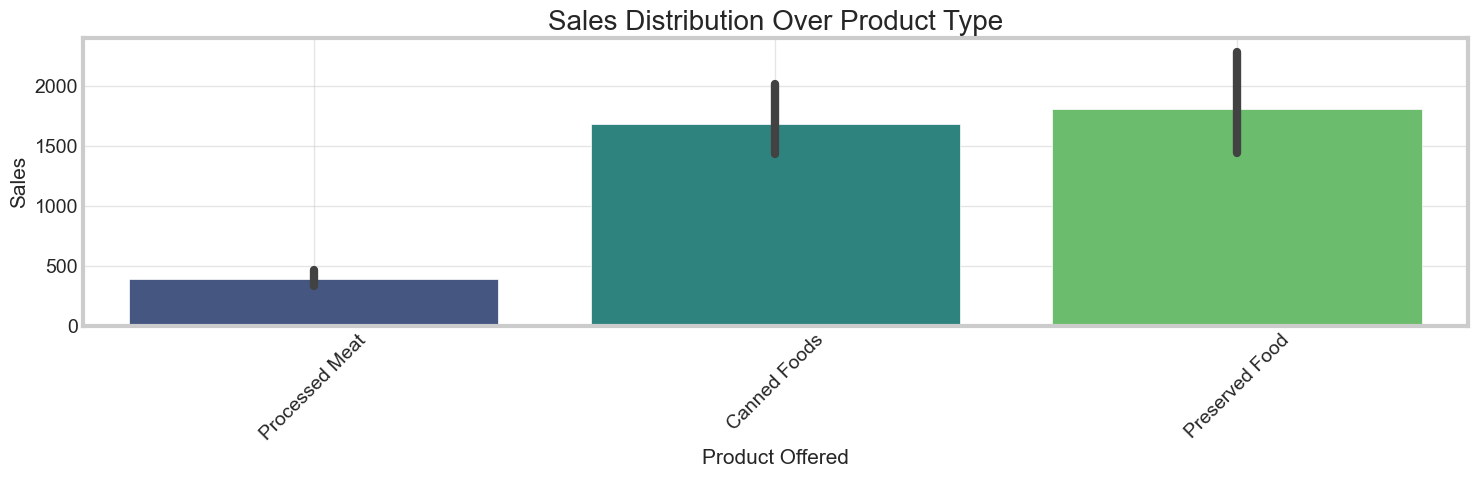

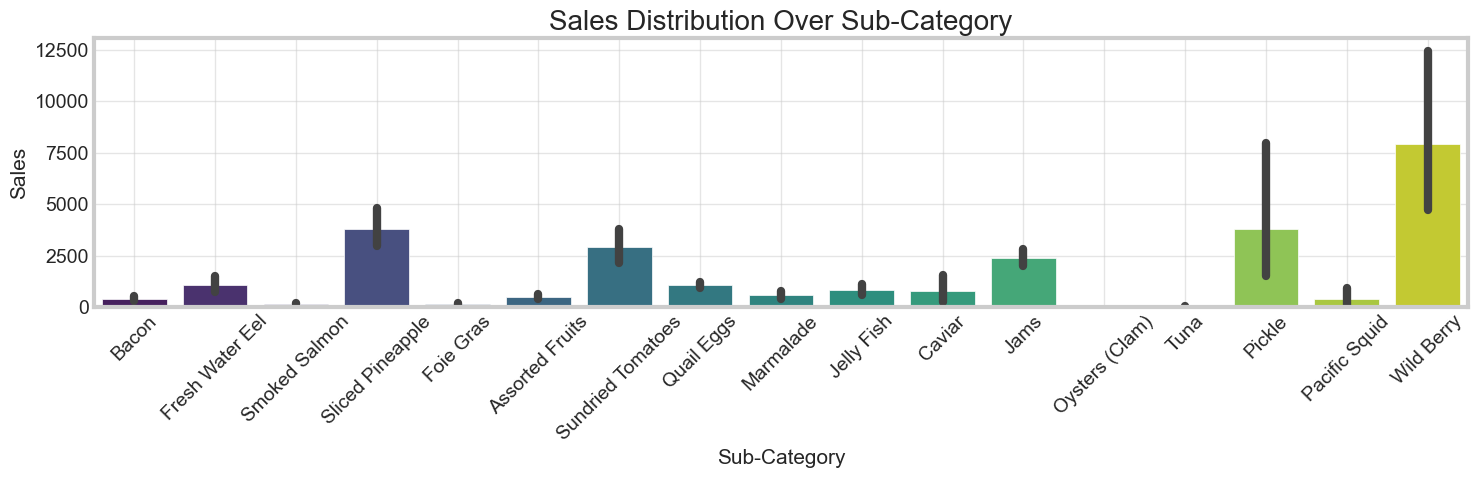

In [123]:
# Sales Distribution Over Product Type
plt.figure(figsize=(15,5))
sns.barplot(x='Product Type',y='Sales',data=df,palette='viridis')
plt.title('Sales Distribution Over Product Type',fontsize=20)
plt.xlabel('Product Offered',fontsize=15)
plt.ylabel('Sales',fontsize=15)
plt.grid(True,alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Sales Distribution Over Sub-Category
plt.figure(figsize=(15,5))
sns.barplot(x='Product Sub-Category',y='Sales',data=df,palette='viridis')
plt.title('Sales Distribution Over Sub-Category',fontsize=20)
plt.xlabel('Sub-Category',fontsize=15)
plt.ylabel('Sales',fontsize=15)
plt.grid(True,alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

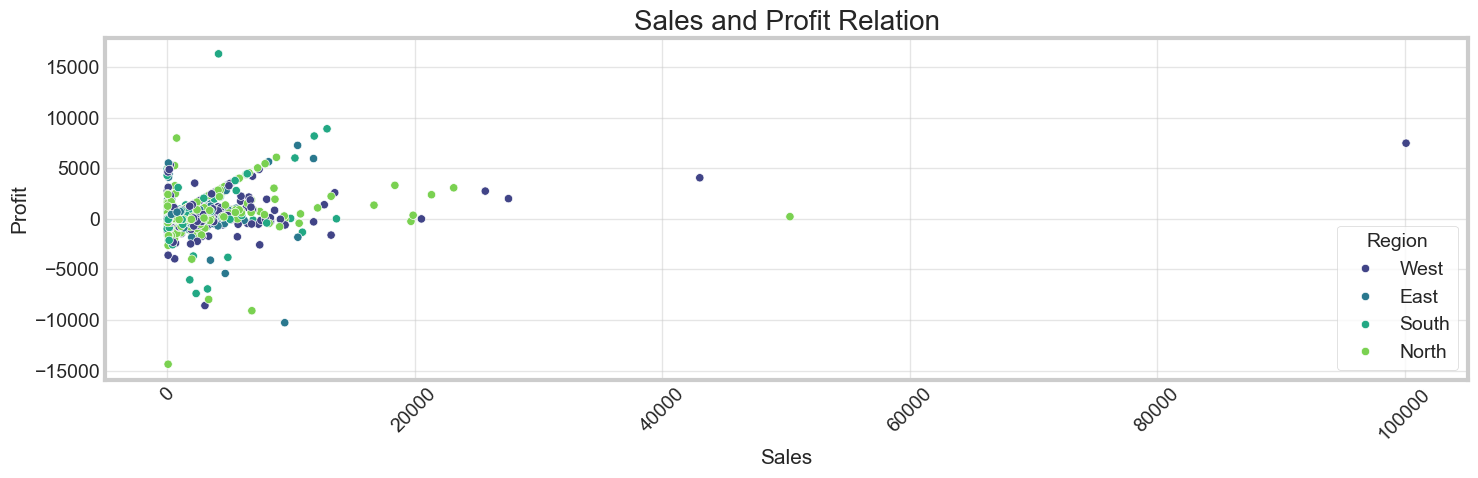

In [124]:
# Sales and Profit Relation
plt.figure(figsize=(15,5))
sns.scatterplot(x='Sales',y='Profit',data=df,palette='viridis',hue='Region')
plt.title('Sales and Profit Relation',fontsize=20)
plt.xlabel('Sales',fontsize=15)
plt.ylabel('Profit',fontsize=15)
plt.grid(True,alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


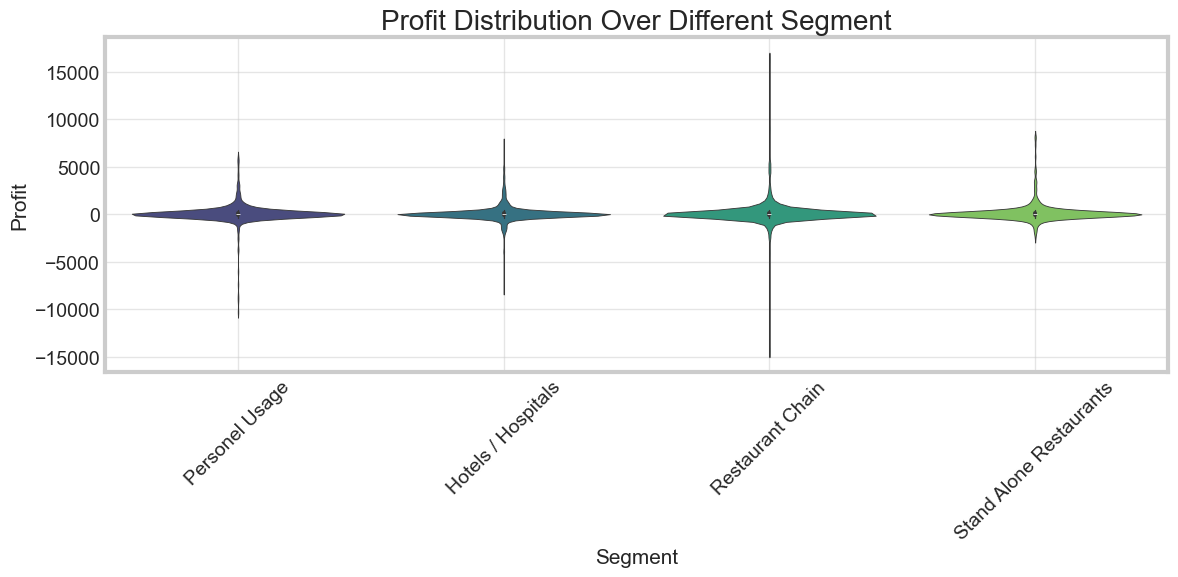

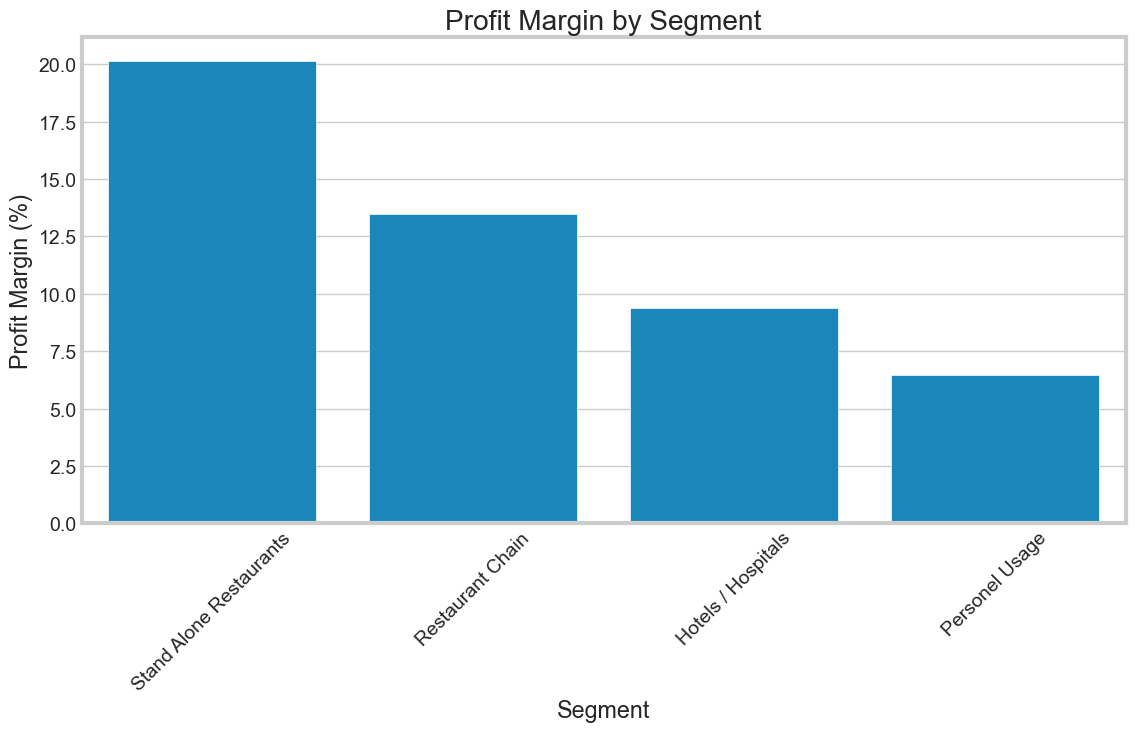

In [125]:
# Profit Distribution Over Different Segment
plt.figure(figsize=(12,6))
sns.violinplot(x='Segment',y='Profit',data=df,palette='viridis')
plt.title('Profit Distribution Over Different Segment',fontsize=20)
plt.xlabel('Segment',fontsize=15)
plt.ylabel('Profit',fontsize=15)
plt.grid(True,alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# We can see from above data that it is too skewed to use violinplot or boxplot so we rather use barplot for better understanding


# Profitability analysis by segment and product type
profit_analysis = df.groupby('Segment')[['Sales', 'Profit']].sum()
profit_analysis['Profit_Margin'] = profit_analysis['Profit'] / profit_analysis['Sales'] * 100
profit_Margin = profit_analysis.sort_values('Profit_Margin', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=profit_Margin.index, y=profit_Margin['Profit_Margin'])
plt.title('Profit Margin by Segment')
plt.ylabel('Profit Margin (%)')
plt.xticks(rotation=45)
plt.show()



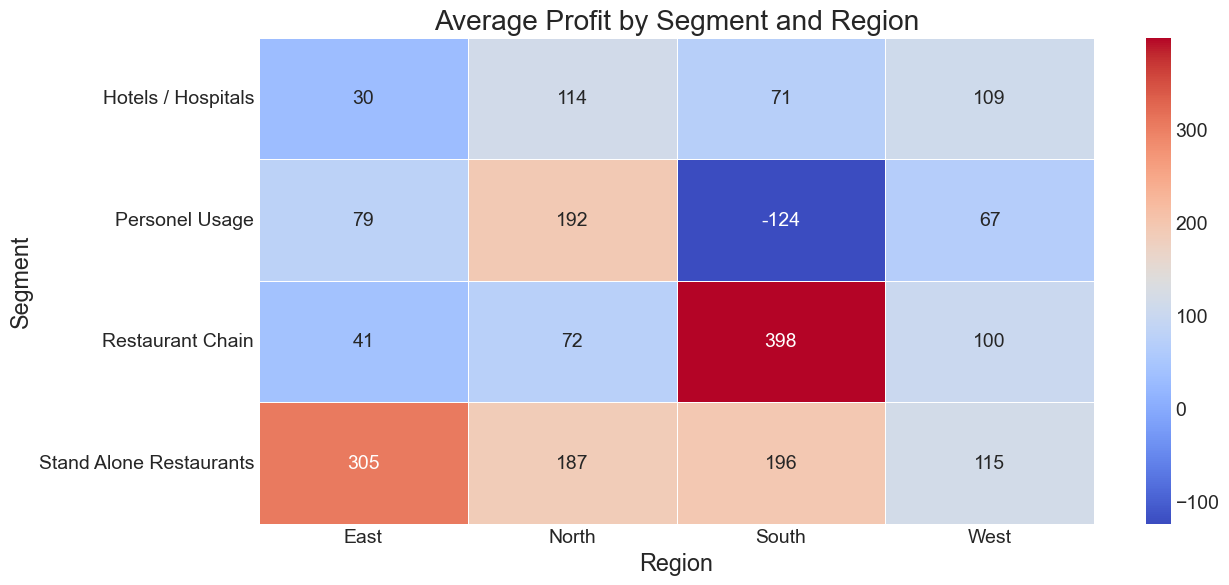

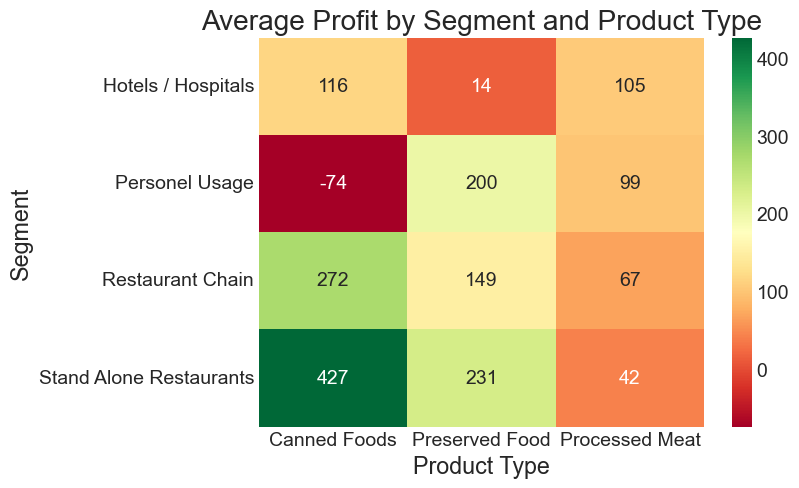

In [126]:
# From the above we can make out that stand alone is doing good while personal usage is not
# Hence we understand from below why is that the reason

# Hence We do Profitability analysis by region and product type
plt.figure(figsize=(12, 6))
pivot = df.pivot_table(values='Profit', index='Segment', columns='Region', aggfunc='mean')
sns.heatmap(pivot, annot=True, fmt=".0f", cmap='coolwarm', linewidths=0.5)
plt.title("Average Profit by Segment and Region")
plt.show()

pivot_ptype = df.pivot_table(values='Profit', index='Segment', columns='Product Type', aggfunc='mean')
sns.heatmap(pivot_ptype, annot=True, fmt=".0f", cmap='RdYlGn')
plt.title("Average Profit by Segment and Product Type")
plt.show()



# 4. Model Training

In [127]:
# For getting Monthly Sales Predction we need to group the data with month region and product type
monthly_sales = df.groupby(['Year_Month', 'Region', 'Product Type'])['Sales'].sum().reset_index()
monthly_sales.head()

,Year_Month,Region,Product Type,Sales
0,2010-01,East,Processed Meat,1379.99
1,2010-01,North,Canned Foods,2519.17
2,2010-01,North,Preserved Food,6135.68
3,2010-01,North,Processed Meat,2128.80
4,2010-01,South,Canned Foods,10782.83


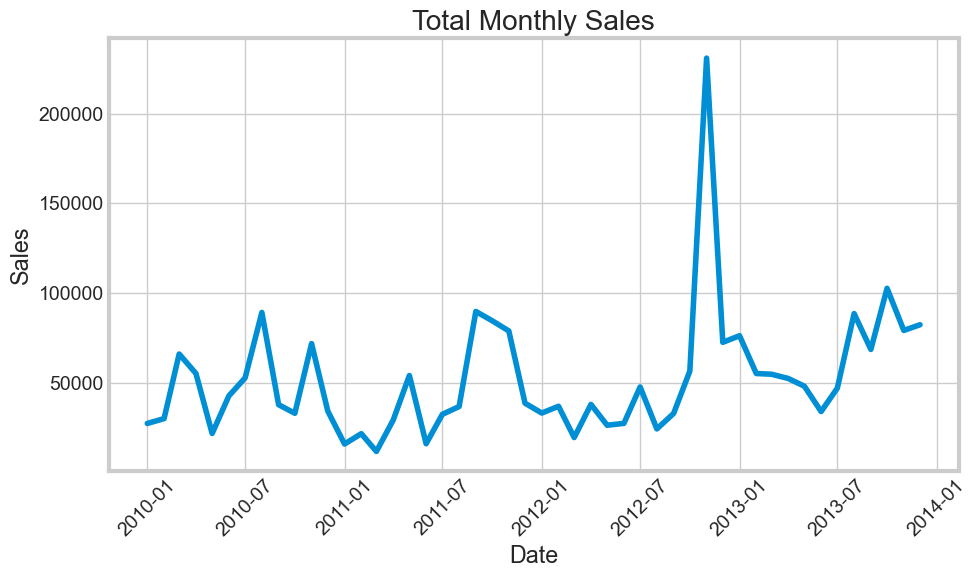

In [128]:
# Convert Year_Month to datetime for time series analysis
monthly_total_sales = monthly_sales.groupby('Year_Month')['Sales'].sum().reset_index()
monthly_total_sales['Year_Month'] = pd.to_datetime(monthly_total_sales['Year_Month'].astype(str) + '-01')
monthly_total_sales.columns = ['ds', 'y']  # Format for Prophet

# Plot total monthly sales
plt.figure(figsize=(10, 6))
plt.plot(monthly_total_sales['ds'], monthly_total_sales['y'])
plt.title('Total Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

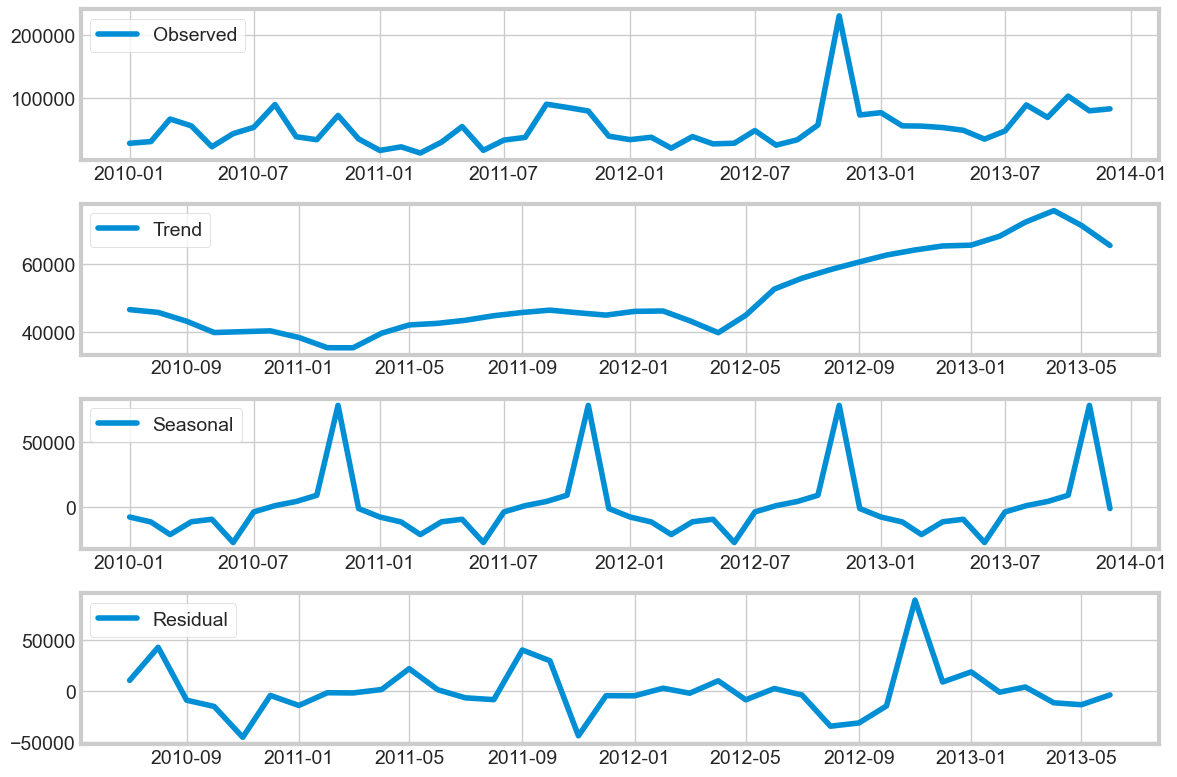

In [129]:
# Time series decomposition
decomposition = seasonal_decompose(monthly_total_sales.set_index('ds')['y'], model='additive', period=12)

# Plotting the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()




In [130]:
# Splitting the data into train and test set
train_size = int(len(monthly_total_sales) * 0.8)
train, test = monthly_total_sales[:train_size], monthly_total_sales[train_size:]

# SHape of the train and test set
train.shape, test.shape


((38, 2), (10, 2))

In [131]:
# Function to evaluate the model
def evaluate_forecast(predictions, actual):
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predictions)
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    
    results = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }
    
    return results

ARIMA Model Evaluation:
MSE: 535417698.47
RMSE: 23139.09
MAE: 18461.62
MAPE: 26.73


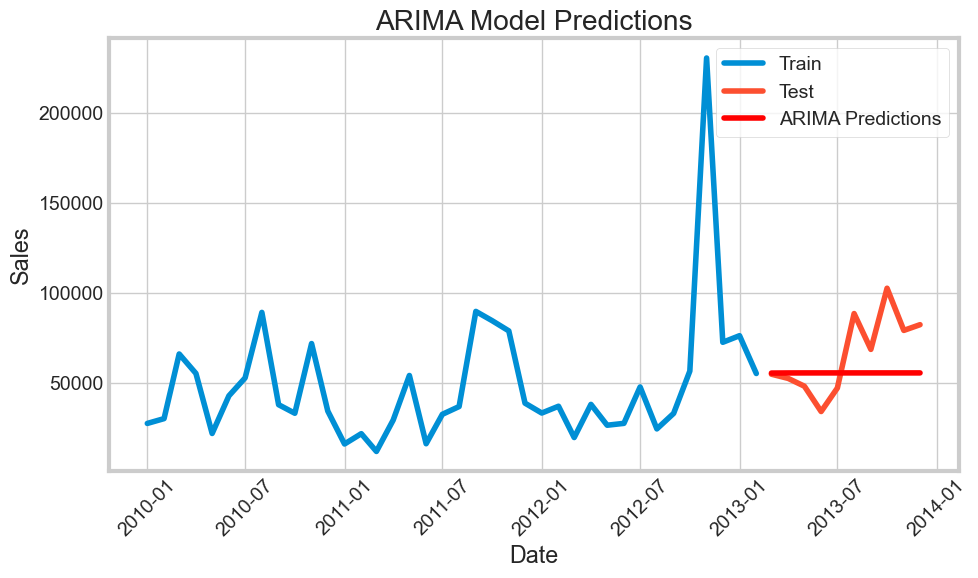

In [132]:
# Arima Model
# Fit the ARIMA model
arima_model = ARIMA(train['y'], order=(1, 1, 1)) 
model_fit = arima_model.fit()

# Make predictions
arima_forecast = model_fit.get_forecast(steps=len(test))
arima_predictions = arima_forecast.predicted_mean


# Evaluate the ARIMA model
arima_results = evaluate_forecast(arima_predictions, test['y'])
print("ARIMA Model Evaluation:")
for key, value in arima_results.items():
    print(f"{key}: {value:.2f}")


# Plotting the ARIMA Model predictions
plt.figure(figsize=(10, 6))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test')
plt.plot(test['ds'], arima_predictions, label='ARIMA Predictions', color='red')
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


04:51:16 - cmdstanpy - INFO - Chain [1] start processing
04:51:16 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Evaluation:
MSE: 5180773232.40
RMSE: 71977.59
MAE: 68317.59
MAPE: 106.49


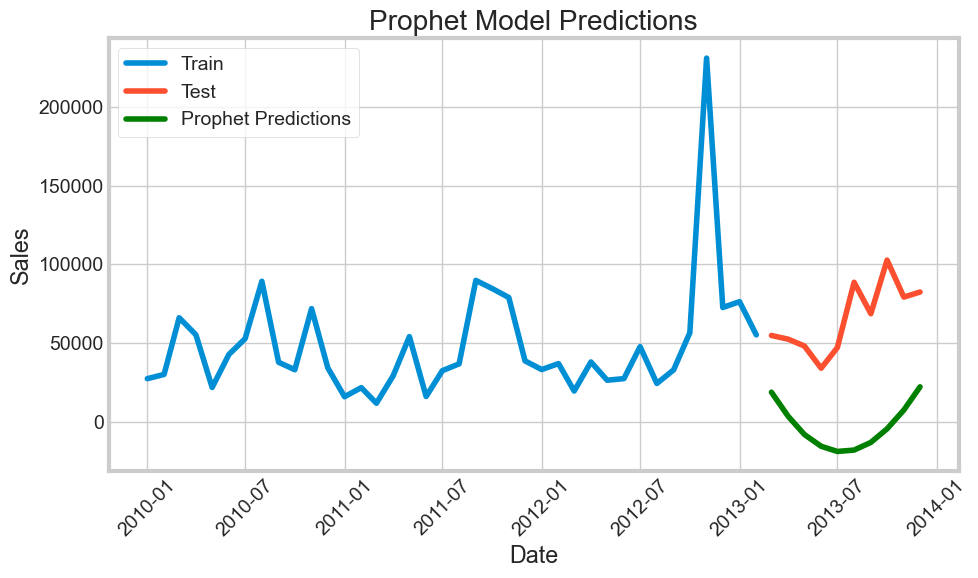

In [133]:
# Prophet Model
# Initialize the Prophet model
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
prophet_model.fit(train)

# Make future predictions
future = prophet_model.make_future_dataframe(periods=len(test))
forecast = prophet_model.predict(future)

# Extract the predictions for the test period
predictions = forecast[-len(test):]['yhat']
# Evaluate the Prophet model
prophet_results = evaluate_forecast(predictions, test['y'])
print("Prophet Model Evaluation:")
for key, value in prophet_results.items():
    print(f"{key}: {value:.2f}")

# Plotting the Prophet Model predictions
plt.figure(figsize=(10, 6))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test')
plt.plot(test['ds'], predictions, label='Prophet Predictions', color='green')
plt.title('Prophet Model Predictions')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 5. Model Comparison

In [134]:
models = [ 'ARIMA', 'Prophet']
evaluations = [ arima_results, prophet_results]

comparison = pd.DataFrame({
    'Model': models,
    'MSE': [e['MSE'] for e in evaluations],
    'RMSE': [e['RMSE'] for e in evaluations],
    'MAE': [e['MAE'] for e in evaluations],
    'MAPE': [e['MAPE'] for e in evaluations]
})

print("\nModel Comparison:")
print(comparison)


Model Comparison:
     Model           MSE          RMSE           MAE        MAPE
0    ARIMA  5.354177e+08  23139.094591  18461.615419   26.728583
1  Prophet  5.180773e+09  71977.588404  68317.585135  106.494853


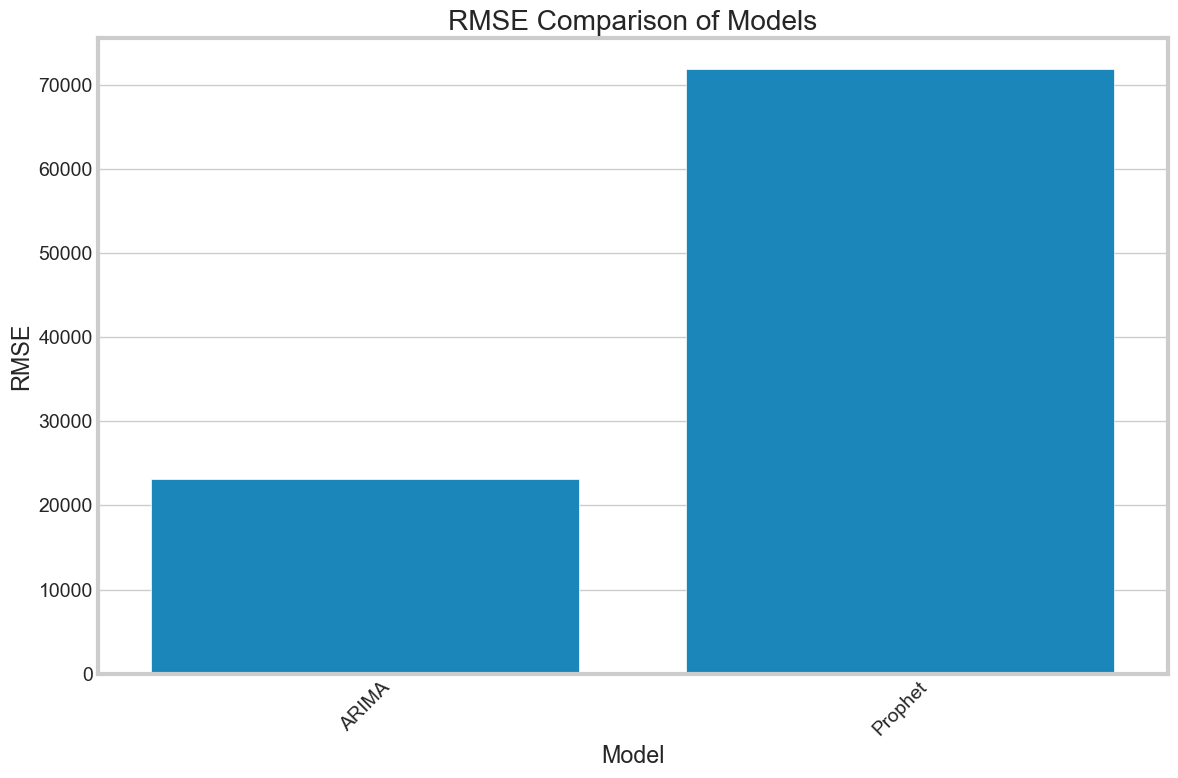

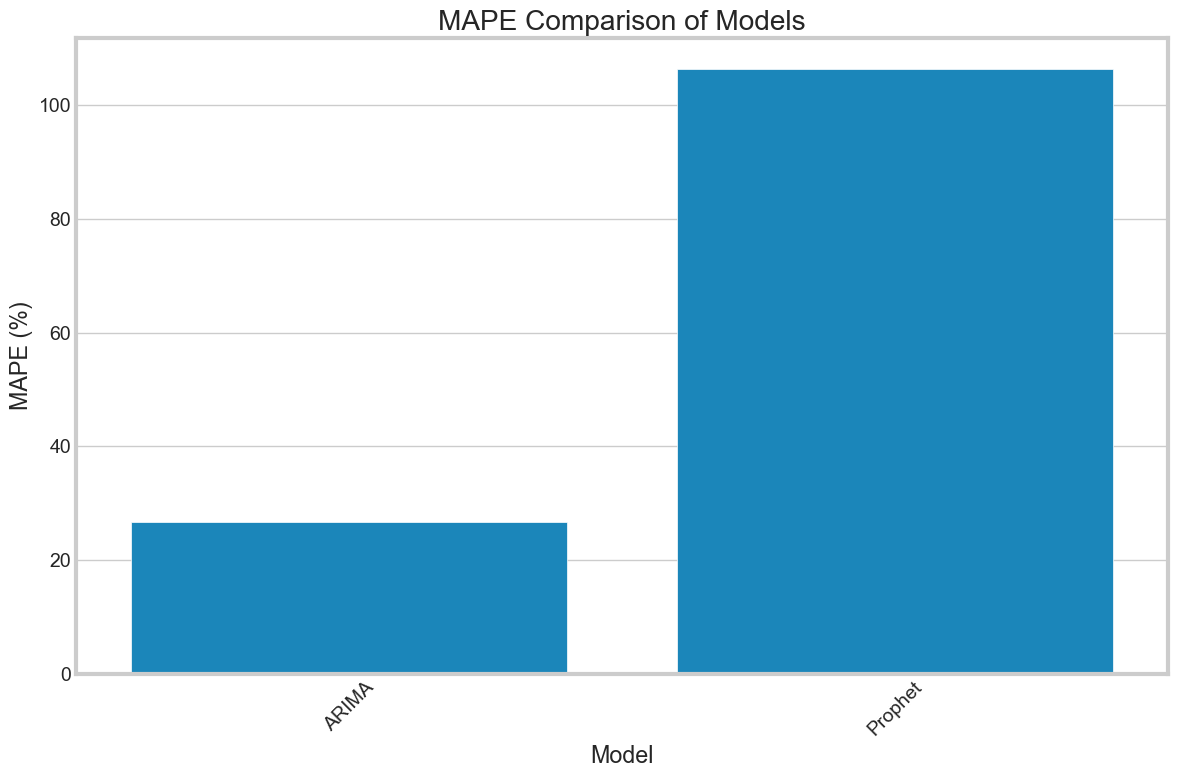

In [135]:
# Plot the comparison of metrics
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='RMSE', data=comparison)
plt.title('RMSE Comparison of Models')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='MAPE', data=comparison)
plt.title('MAPE Comparison of Models')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. Best Model Selection and Future Forecasting

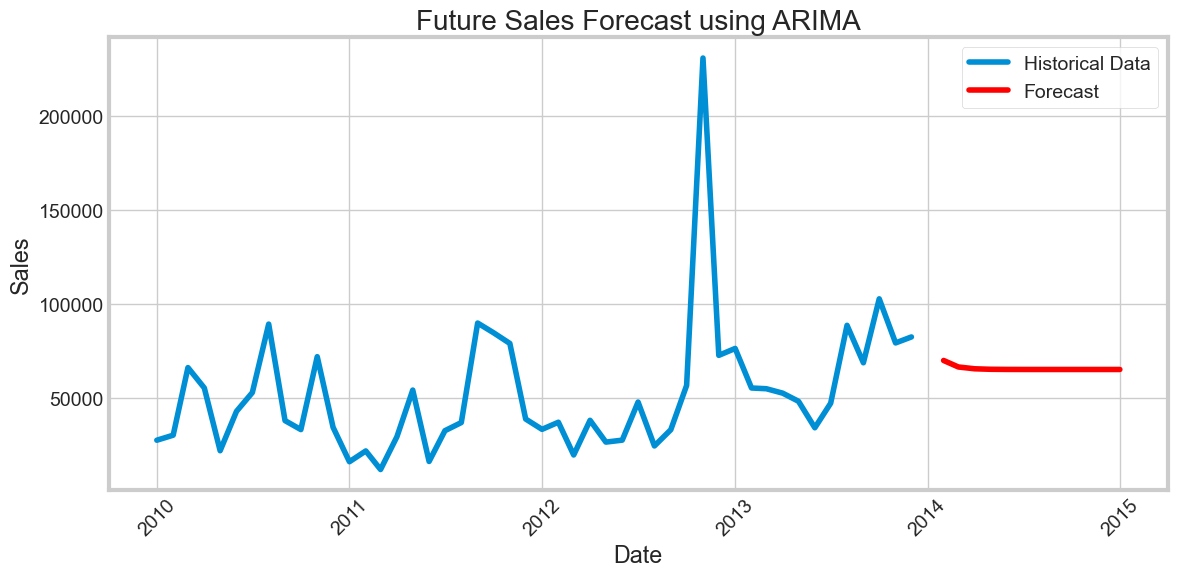

In [136]:
# Find the best model based on RMSE
best_model_index = comparison['RMSE'].idxmin()
best_model = models[best_model_index]


# Generating future forecasts with the best model
# For demonstration we will forecast 12 months ahead
future_periods = 12
if best_model == 'ARIMA':
    # Fitting the arima model on full data
    final_arima_model = ARIMA(monthly_total_sales['y'], order=(1, 1, 1)).fit()
    
    # Forecast
    future_forecast = final_arima_model.forecast(steps=future_periods)
    
    # Generating future dates
    last_date = monthly_total_sales['ds'].iloc[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_periods, freq='M')
    future_df = pd.DataFrame({'ds': future_dates, 'forecast': future_forecast})
    
    # Plotting the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_total_sales['ds'], monthly_total_sales['y'], label='Historical Data')
    plt.plot(future_df['ds'], future_df['forecast'], label='Forecast', color='red')
    plt.title(f'Future Sales Forecast using {best_model}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else: # (Prophet)
    # Fit model on full data
    final_prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    final_prophet_model.fit(monthly_total_sales)
    
    # Creating future dataframe
    future = final_prophet_model.make_future_dataframe(periods=future_periods, freq='M')
    
    # Forecast
    future_forecast = final_prophet_model.predict(future)
    
    # Plotting the prophet forecast
    fig = final_prophet_model.plot(future_forecast)
    plt.title(f'Future Sales Forecast using {best_model}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend(['Historical', 'Forecast', 'Uncertainty Interval'])
    plt.tight_layout()
    plt.show()


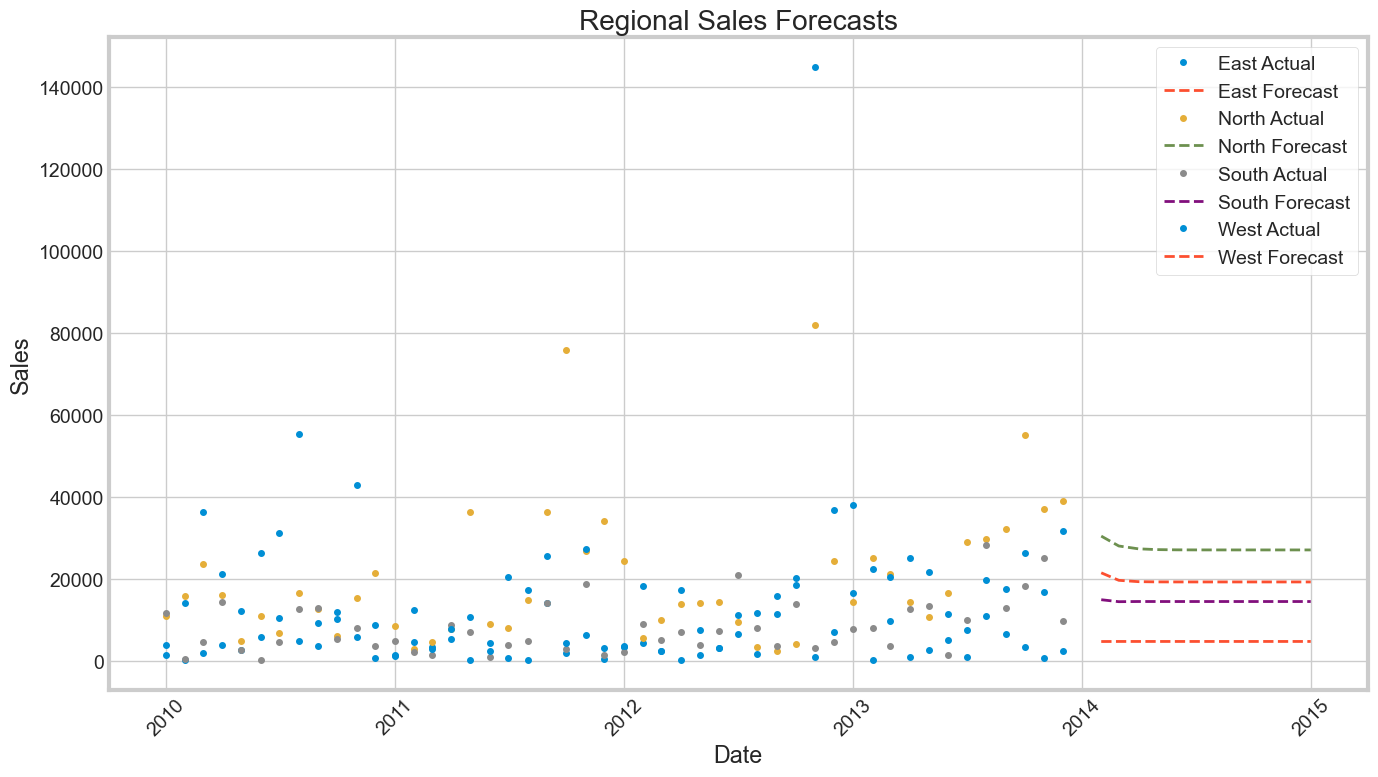

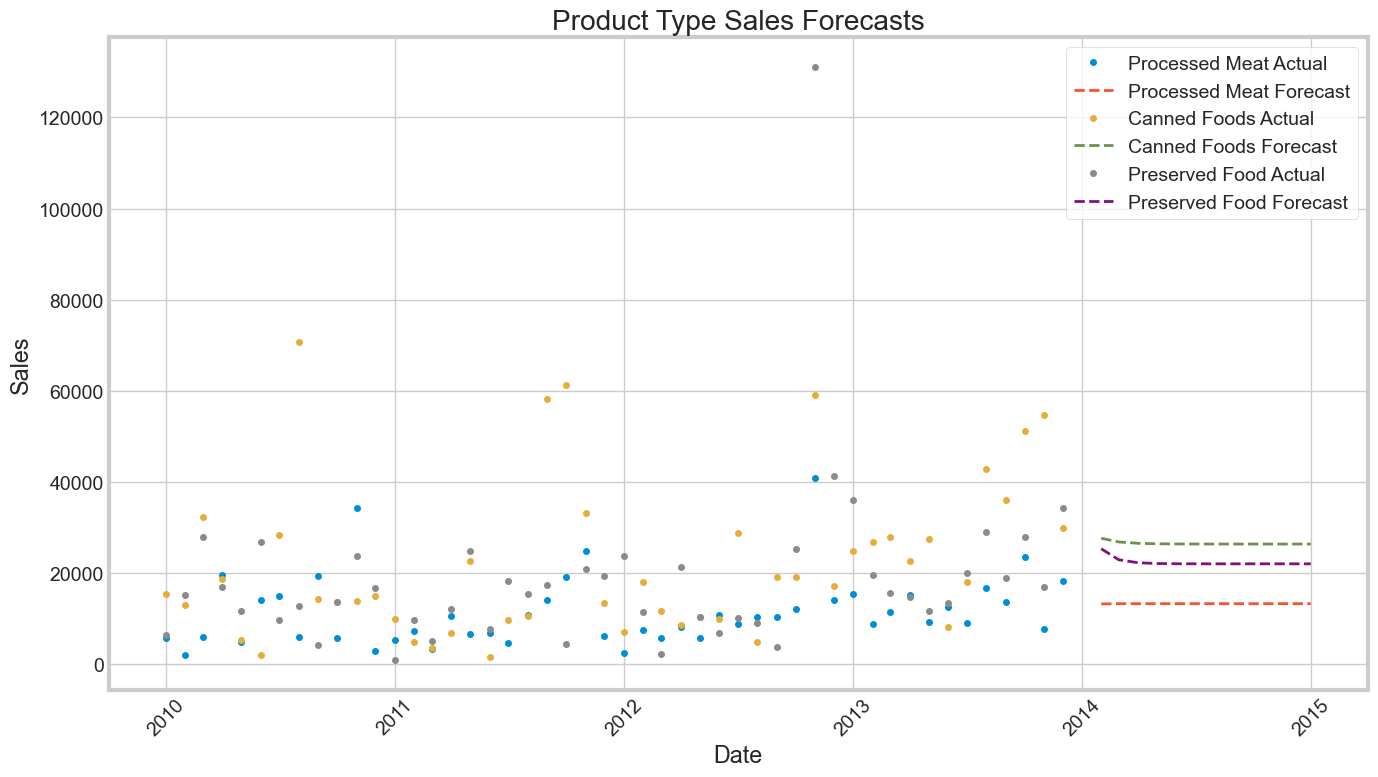

In [141]:

# Forecasting for each region using Arima

# Get unique regions
regions = monthly_sales['Region'].unique()

plt.figure(figsize=(14, 8))

for region in regions:
    
    region_data = monthly_sales[monthly_sales['Region'] == region]
    region_monthly = region_data.groupby('Year_Month')['Sales'].sum().reset_index()
    region_monthly['Year_Month'] = pd.to_datetime(region_monthly['Year_Month'].astype(str) + '-01')
    region_monthly.columns = ['ds', 'y']
    
    # Trainig the Arima model as it is the best model
    region_model = ARIMA(region_monthly['y'], order=(1, 1, 1))
    region_model_fit = region_model.fit()
    
    # Creating future dates
    last_date = region_monthly['ds'].iloc[-1]
    region_future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_periods, freq='M')
    
    # Forecast
    region_forecast_values = region_model_fit.forecast(steps=future_periods)
    region_forecast = pd.DataFrame({'ds': region_future_dates, 'yhat': region_forecast_values})
    
    # Plotting the result of the forecast
    plt.plot(region_monthly['ds'], region_monthly['y'], 'o', markersize=4, label=f"{region} Actual")
    plt.plot(region_forecast['ds'][-future_periods:], region_forecast['yhat'][-future_periods:], 
             '--', linewidth=2, label=f"{region} Forecast")

plt.title('Regional Sales Forecasts')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Get unique product types
product_types = monthly_sales['Product Type'].unique()

plt.figure(figsize=(14, 8))

for product in product_types:
    
    product_data = monthly_sales[monthly_sales['Product Type'] == product]
    product_monthly = product_data.groupby('Year_Month')['Sales'].sum().reset_index()
    product_monthly['Year_Month'] = pd.to_datetime(product_monthly['Year_Month'].astype(str) + '-01')
    product_monthly.columns = ['ds', 'y']
    
    # Training ARIMA model
    product_model = ARIMA(product_monthly['y'], order=(1, 1, 1))
    product_model_fit = product_model.fit()
    
    # Creating future dates
    last_date = product_monthly['ds'].iloc[-1]
    product_future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_periods, freq='M')
    
    # Forecast
    product_forecast_values = product_model_fit.forecast(steps=future_periods)
    product_forecast = pd.DataFrame({'ds': product_future_dates, 'yhat': product_forecast_values})
    
    # Plotting the forecast result
    plt.plot(product_monthly['ds'], product_monthly['y'], 'o', markersize=4, label=f"{product} Actual")
    plt.plot(product_forecast['ds'][-future_periods:], product_forecast['yhat'][-future_periods:], 
             '--', linewidth=2, label=f"{product} Forecast")

plt.title('Product Type Sales Forecasts')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
